# 2. How would you address the issue of low resolution image(detection_&_recognition.png)?

**Ans:** In this problem, I have applied non local means denoising algorithm to dneoise the image. At first, the algorithm is directly applied on the RGB image. Next, I have performed histogram equalization on the grayscale image(converted from RGB) and performed the non local means denoising algorithm. Next, I have converted the RGB image to HSV color space and applied the algorithm on the intensity image.

In all the cases, the algorithm can denoise the image, but can not completely handle the blurring regions.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(<Axes: title={'center': 'Denoised combined RGB image'}>,
 Text(0.5, 1.0, 'Denoised combined RGB image'),
 <matplotlib.image.AxesImage at 0x7bfe65bae6d0>)

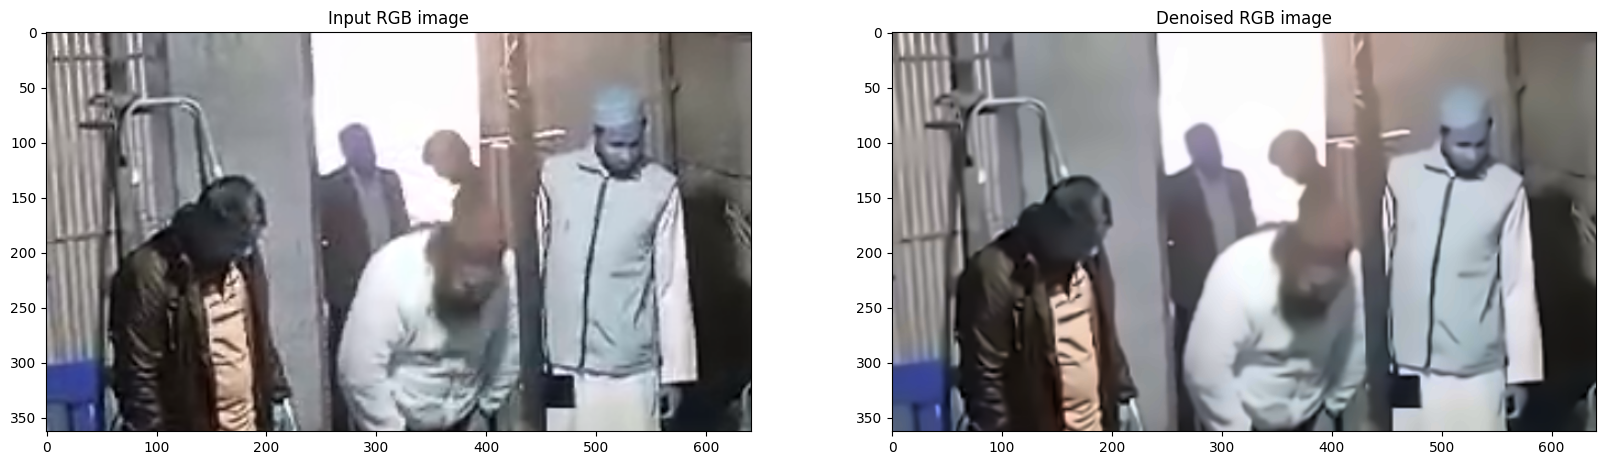

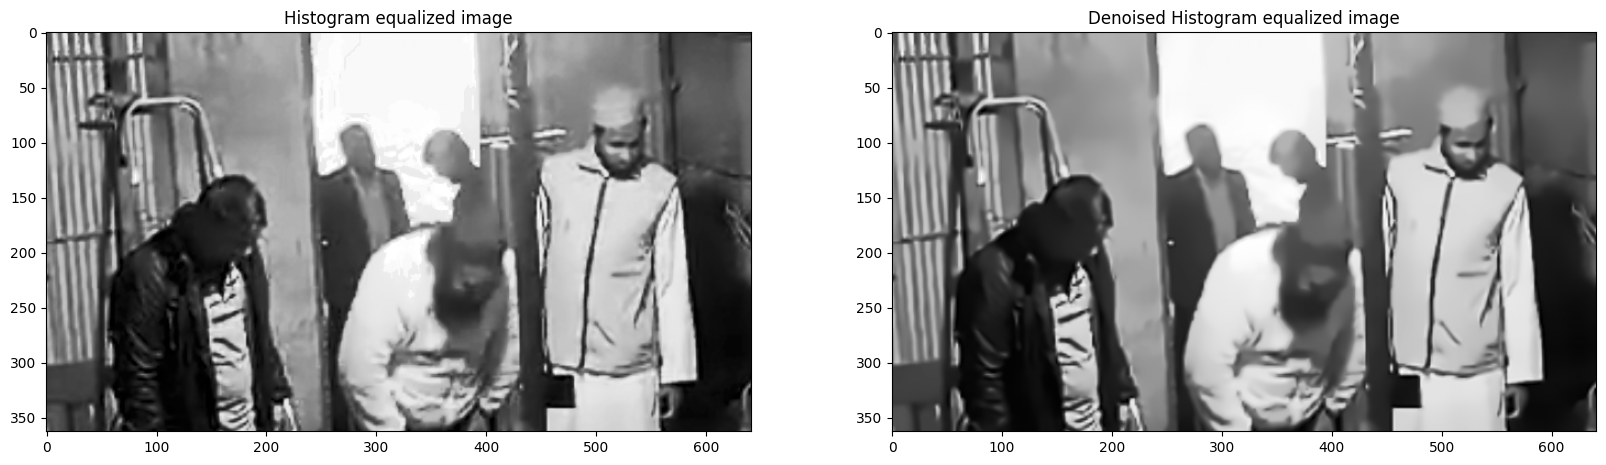

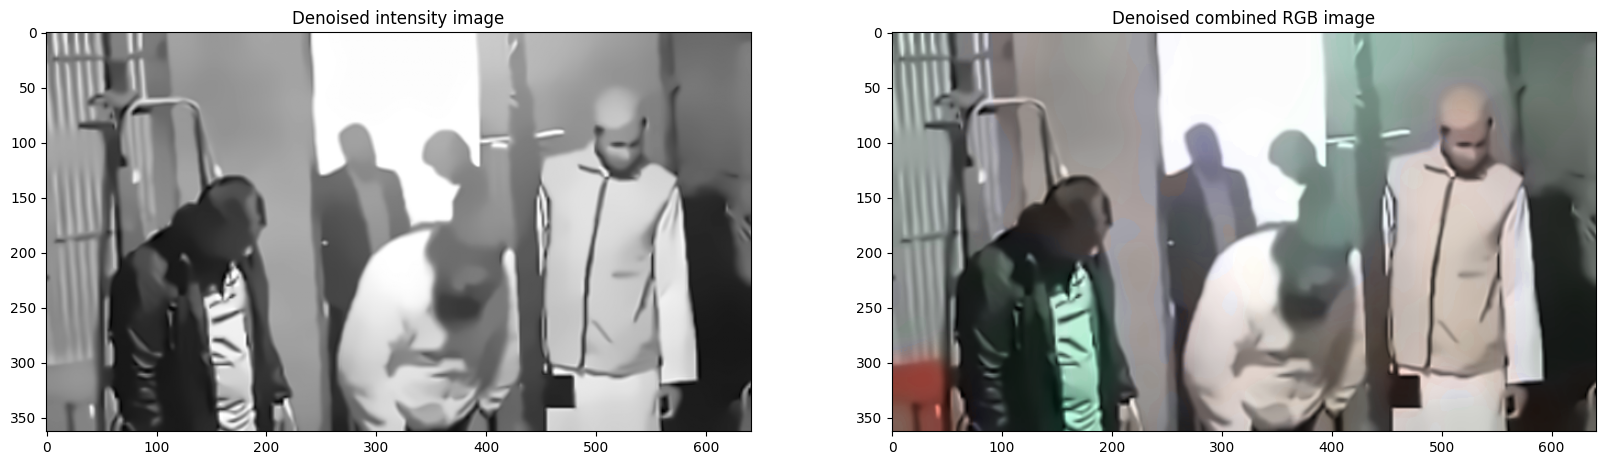

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from scipy.signal import convolve2d as conv2
from skimage import restoration
from google.colab import files
import os
from skimage import color, restoration
from google.colab import drive
drive.mount('/content/drive')

# Load image
image_path = '/content/drive/My Drive/Colab_Files/detection_&_recognition.png'
input_image = cv2.imread(image_path)

gray_input = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray_input)

# Apply non-local means denoising on the RGB image
denoised_image = cv2.fastNlMeansDenoisingColored(input_image, None, 10, 10, 7, 21)

# Apply non-local means denoising on the histogram equalized image
denoised_equ = cv2.fastNlMeansDenoising(equ, None, 10, 7, 21)

# convert the RGB image to HSV space
hsv_image = cv2.cvtColor(denoised_image, cv2.COLOR_BGR2HSV)

# Separating the hue, saturation and intensity channels
hue_img = hsv_image[:, :, 0]
sat_img = hsv_image[:, :, 1]
val_img = hsv_image[:, :, 2]

# Applying non-local means denoising on the intensity image
denoised_image_intensity_hsv = cv2.fastNlMeansDenoising(val_img, None, 10, 7, 21)

# COnverting the numpy arrays into PIL to use inside merge() later
hue_img_pil = Image.fromarray(hue_img)
sat_img_pil = Image.fromarray(sat_img)
denoised_image_intensity_hsv_pil = Image.fromarray(denoised_image_intensity_hsv)

# COmbining the denoised intensity channel with hue and saturation channels
combined_HSV = Image.merge(mode="HSV", bands=(hue_img_pil, sat_img_pil, denoised_image_intensity_hsv_pil)).convert('RGB')

# Plotting figures
plt.figure(figsize=(20,6))
plt.subplot(1,2,1), plt.gca().set_title('Input RGB image'), plt.imshow(input_image)
plt.subplot(1,2,2), plt.gca().set_title('Denoised RGB image'), plt.imshow(denoised_image)
plt.figure(figsize=(20,6))
plt.subplot(1,2,1), plt.gca().set_title('Histogram equalized image'), plt.imshow(equ, cmap='gray')
plt.subplot(1,2,2), plt.gca().set_title('Denoised Histogram equalized image'), plt.imshow(denoised_equ, cmap='gray')
plt.figure(figsize=(20,6))
plt.subplot(1,2,1), plt.gca().set_title('Denoised intensity image'), plt.imshow(denoised_image_intensity_hsv, cmap='gray')
plt.subplot(1,2,2), plt.gca().set_title('Denoised combined RGB image'), plt.imshow(combined_HSV, cmap='gray')

# How would you address the issue of challenging lighting condition in the image?

Ans: To handle the challenging lighting condition, the white balance is applied on the image first, where the scaling factors are computed for each channel based on average colors and multiplied with each channel of the image. The blur in the image gets reduced but overall the image gets darker. So, color temparature adjustment is applied by adding a cool temparature on the balanced image. In this way, the challenging lighting condition is comparatively reduced.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(<matplotlib.image.AxesImage at 0x7bfe651da2d0>,
 Text(0.5, 1.0, 'Cool tempered image'))

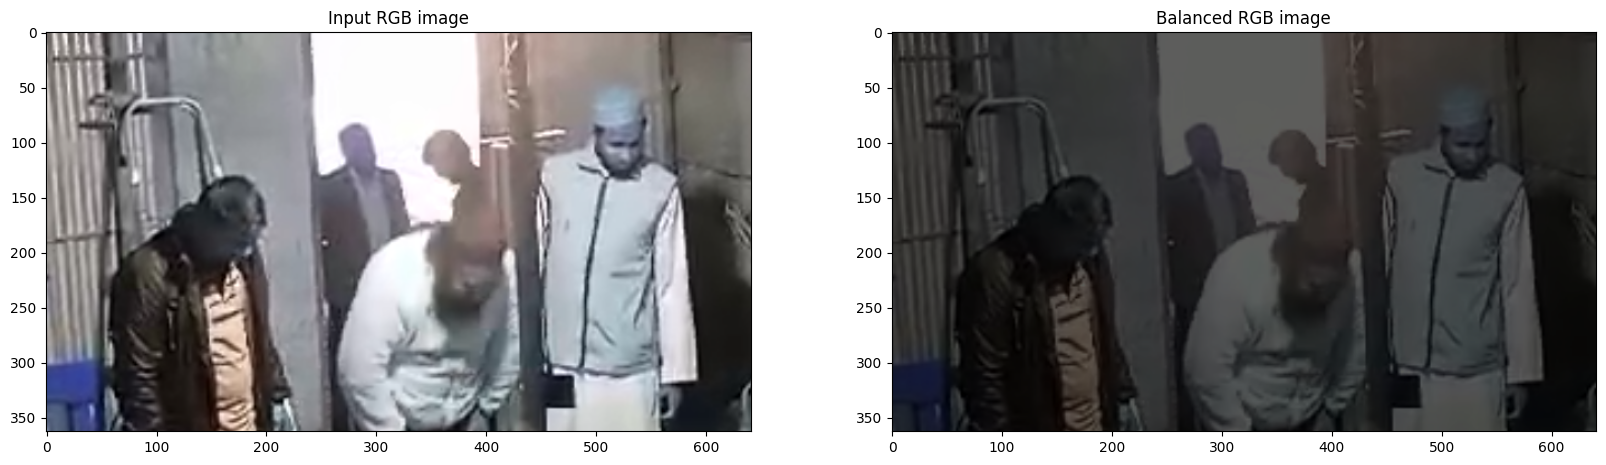

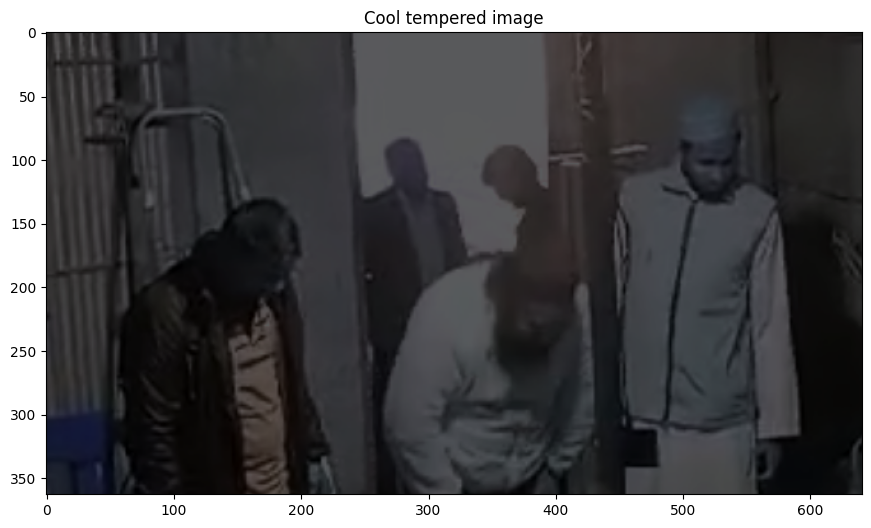

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

# Load image
image_path = '/content/drive/My Drive/Colab_Files/detection_&_recognition.png'
input_image = cv2.imread(image_path)

# A function is written to perform white balance
def white_balance(image, sf=50):
    # Convert the image to float32
    img_float = image.astype(np.float32)

    # Calculate the average color of the image to compute the scaling factor
    avg_color = np.mean(img_float, axis=(0, 1))

    # Calculate the scaling factors
    scale = sf / avg_color

    # Apply the scaling factors to each channel
    img_balanced = img_float * scale
    # Clip the values to be in the valid range [0, 255]
    img_balanced = np.clip(img_balanced, 0, 255).astype(np.uint8)

    return img_balanced

# White balance function is called
balanced_image = white_balance(input_image, sf=50)

plt.figure(figsize=(20,6))
plt.subplot(1,2,1), plt.gca().set_title('Input RGB image'), plt.imshow(input_image)
plt.subplot(1,2,2), plt.gca().set_title('Balanced RGB image'), plt.imshow(balanced_image)

# Reference of Kelvin to RGB mapping table: https://stackoverflow.com/questions/11884544/setting-color-temperature-for-a-given-image-like-in-photoshop/11888449#11888449
kelvin_table = {
    1000: (255, 56, 0),
    1500: (255, 109, 0),
    2000: (255, 137, 18),
    2500: (255, 161, 72),
    3000: (255, 180, 107),
    3500: (255, 196, 137),
    4000: (255, 209, 163),
    4500: (255, 219, 186),
    5000: (255, 228, 206),
    5500: (255, 236, 224),
    6000: (255, 243, 239),
    6500: (255, 249, 253),
    7000: (245, 243, 255),
    7500: (235, 238, 255),
    8000: (227, 233, 255),
    8500: (220, 229, 255),
    9000: (214, 225, 255),
    9500: (208, 222, 255),
    10000: (204, 219, 255)
}

input_image = Image.fromarray(balanced_image)

# A cool temparature parameter is set
temperature_cool = 8500

# The cool color temperature parameter is passed in the kelvin_table dictionary to get the red, green and blue channel values for scaling
r_1, g_1, b_1 = kelvin_table[temperature_cool]

# Matrix to compute the cool values of red, green and blue channels
matrix_cool = (
        r_1 / 255.0, 0.0, 0.0, 0.0,
        0.0, g_1 / 255.0, 0.0, 0.0,
        0.0, 0.0, b_1 / 255.0, 0.0
    )

# The input image is converted into a new cool image using the scaling parameters saved in matrix_cool
tempered_image_cool = input_image.convert('RGB', matrix_cool)


# Plotting the results
plt.figure(figsize=(20,6))
plt.imshow(tempered_image_cool), plt.title('Cool tempered image')

# Make a python function that will draw a bounding box around an object(clock) in the given image.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(<Axes: title={'center': 'Rectangular bounding box around the clock'}>,
 Text(0.5, 1.0, 'Rectangular bounding box around the clock'))

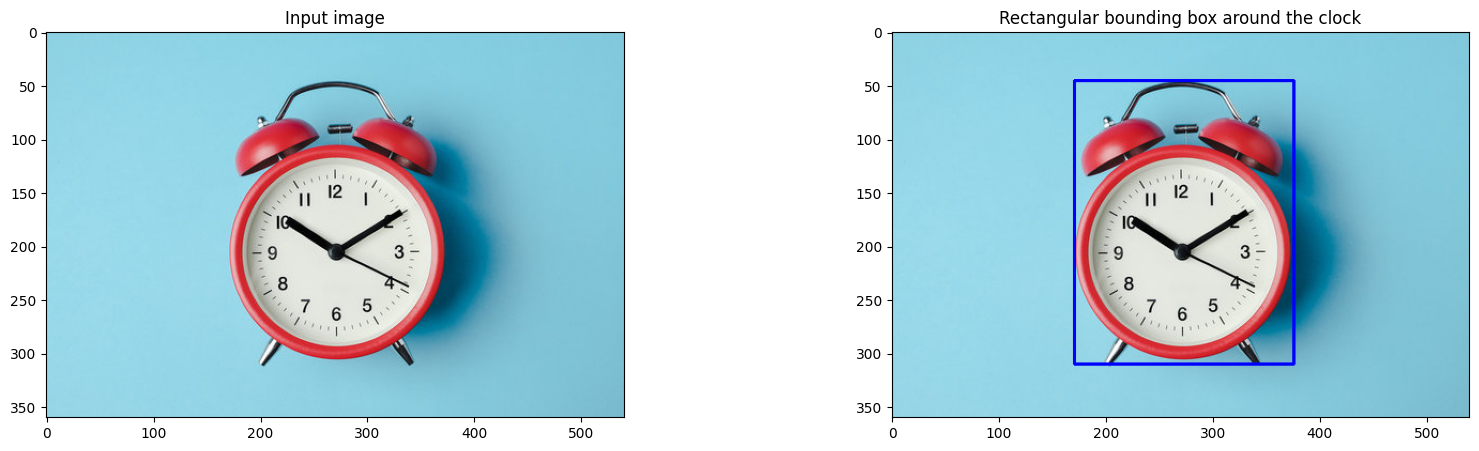

In [70]:
from google.colab import drive
drive.mount('/content/drive')

# Loading packages
import cv2
import matplotlib.pyplot as plt
import numpy as np

# taking the image as input
image_path = '/content/drive/My Drive/Colab_Files/clock.jpg'
input_img_rose = cv2.imread(image_path)

# converting the input image to RGB and HSV
img_rgb_rose = cv2.cvtColor(input_img_rose, cv2.COLOR_BGR2RGB)

# The top left coordinates(x_min,y_min) and bottom right coordinates(x_max,y_max) are selected manually
x_min = 170
y_min = 45

x_max = 375
y_max = 310

# A copy of the original RGB image is made so that the bounding box is not drawn multiple times as the coordinates were found by trial and error
image_copy = img_rgb_rose.copy()

# The bounding box is drawn using the rectangle() in OpenCV
bounding_box = cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(0,0,255), thickness=2)

# Plotting the results
plt.figure(figsize=(20,5))
plt.subplot(1,2,1), plt.imshow(img_rgb_rose), plt.title('Input image')
plt.subplot(1,2,2),plt.imshow(bounding_box), plt.title('Rectangular bounding box around the clock')
